In [1]:
import pennylane as qml
from pennylane import numpy as np

In [87]:
graph = [(0, 1), (0, 3), (1, 2), (2, 3), (3, 4), (1, 4), (4, 5)]
n_wires = len(graph)

# unitary operator U_B with parameter beta
def U_B(beta):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)


# unitary operator U_C with parameter gamma
def U_C(gamma):
    for edge in graph:
        wire1 = edge[0]
        wire2 = edge[1]
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(gamma, wires=wire2)
        qml.CNOT(wires=[wire1, wire2])

In [88]:
def comp_basis_measurement(wires):
    n_wires = len(wires)
    return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)

In [89]:
dev = qml.device("default.qubit", wires=n_wires, analytic=True, shots=1)

In [90]:
pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z)


@qml.qnode(dev)
def circuit(gammas, betas, edge=None, n_layers=1):
    # apply Hadamards to get the n qubit |+> state
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    # p instances of unitary operators
    for i in range(n_layers):
        U_C(gammas[i])
        U_B(betas[i])
    if edge is None:
        # measurement phase
        return qml.sample(comp_basis_measurement(range(n_wires)))
    # during the optimization phase we are evaluating a term
    # in the objective using expval
    return qml.expval(qml.Hermitian(pauli_z_2, wires=edge))

In [91]:
def qaoa_maxcut(n_layers=1):
    print("\np={:d}".format(n_layers))

    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(2, n_layers)

    # minimize the negative of the objective function
    def objective(params):
        gammas = params[0]
        betas = params[1]
        neg_obj = 0
        for edge in graph:
            # objective for the MaxCut problem
            neg_obj -= 0.5 * (1 - circuit(gammas, betas, edge=edge, n_layers=n_layers))
        return neg_obj

    # initialize optimizer: Adagrad works well empirically
    opt = qml.AdagradOptimizer(stepsize=0.5)

    # optimize parameters in objective
    params = init_params
    steps = 30
    for i in range(steps):
        params = opt.step(objective, params)
        if (i + 1) % 5 == 0:
            print("Objective after step {:5d}: {: .7f}".format(i + 1, -objective(params)))

    # sample measured bitstrings 100 times
    bit_strings = []
    n_samples = 100
    for i in range(0, n_samples):
        bit_strings.append(int(circuit(params[0], params[1], edge=None, n_layers=n_layers)))

    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)
    print("Optimized (gamma, beta) vectors:\n{}".format(params[:, :n_layers]))
    print("Most frequently sampled bit string is: {:04b}".format(most_freq_bit_string))

    return -objective(params), bit_strings


# perform qaoa on our graph with p=1,2 and
# keep the bitstring sample lists
bitstrings1 = qaoa_maxcut(n_layers=1)[1]
bitstrings2 = qaoa_maxcut(n_layers=2)[1]
bitstrings3 = qaoa_maxcut(n_layers=3)[1]


p=1
Objective after step     5:  4.7590814
Objective after step    10:  5.0008001
Objective after step    15:  5.0019676
Objective after step    20:  5.0019731
Objective after step    25:  5.0019731
Objective after step    30:  5.0019731
Optimized (gamma, beta) vectors:
[[-0.69121745]
 [-1.17809747]]
Most frequently sampled bit string is: 101011

p=2
Objective after step     5:  3.3437815
Objective after step    10:  5.1323787
Objective after step    15:  5.5073436
Objective after step    20:  5.6949274
Objective after step    25:  5.7946526
Objective after step    30:  5.8451432
Optimized (gamma, beta) vectors:
[[ 0.8839909  -0.44409062]
 [-1.15654532 -0.82478293]]
Most frequently sampled bit string is: 101010

p=3
Objective after step     5:  5.7941768
Objective after step    10:  5.6857105
Objective after step    15:  6.1976434
Objective after step    20:  6.2610770
Objective after step    25:  6.2645831
Objective after step    30:  5.9243997
Optimized (gamma, beta) vectors:
[[-0.2

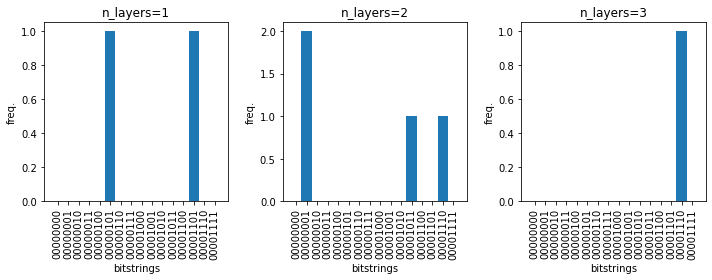

In [92]:
import matplotlib.pyplot as plt

xticks = range(0, 16)
xtick_labels = list(map(lambda x: format(x, "08b"), xticks))
bins = np.arange(0, 17) - 0.5

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title("n_layers=1")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings1, bins=bins)

plt.subplot(1, 3, 2)
plt.title("n_layers=2")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings2, bins=bins)

plt.subplot(1, 3, 3)
plt.title("n_layers=3")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings3, bins=bins)

plt.tight_layout()
plt.show()